In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smapi
import statsmodels.tsa.stattools as ts
import quandl
import warnings
import xgboost as xgb
import lightgbm as lgb

warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error


pd.set_option("display.max.rows", 3000)
pd.set_option("display.max.columns", 3000)

<H2 align="center"> Modeling and Forecasting Inflation in the United States<br> <br> Using Stacked Regressions<br> <br>   

### Introduction

This jupyter notebook uses stacked regressions to forecast the CPI in the United States. Inflation is one of the most imperative indicators of future economic activity. It affects the decisions of investors, governments, and policy makers. Inflation targeting is a monetary policy regime in which the Federal Reserve policymakers target an inflation rate of two percent. The assumption is that the best that monetary policy can do to support long-term growth of the economy is to maintain price stability. By forecasting inflation, investors can theoretically gain an edge in predicting; future monetary policy actions, bond price movements and the future health of the economy.

### Data

In [178]:
CPI = quandl.get("RATEINF/INFLATION_USA", authtoken="ExYhsQRV9jyhdRQWb_s8")  #Slutet av månaden YoY
CPI_columns =["CPI"]
CPI.columns = CPI_columns

CL1 = quandl.get("CHRIS/CME_CL1", authtoken="ExYhsQRV9jyhdRQWb_s8", collapse="monthly") #Slutet av månaden
CL1 = CL1["Last"]

Copper = quandl.get("CHRIS/CME_HG1", authtoken="ExYhsQRV9jyhdRQWb_s8", collapse="monthly") #Slutet av månaden
Copper = Copper["High"]

UnemploymentRate = quandl.get("FRED/UNRATE", authtoken="ExYhsQRV9jyhdRQWb_s8")
UnemploymentRate.index = pd.to_datetime(UnemploymentRate.index) + pd.offsets.MonthEnd(0)
EmploymentRate = (1 - UnemploymentRate)        

HousingStarts = quandl.get("FRED/HOUST", authtoken="ExYhsQRV9jyhdRQWb_s8")
HousingStarts.index = pd.to_datetime(HousingStarts.index) + pd.offsets.MonthEnd(0)

Earnings = quandl.get("FRED/AHETPI", authtoken="ExYhsQRV9jyhdRQWb_s8", collapse="monthly")

In [179]:
df = pd.concat([CPI, CL1, Copper, EmploymentRate, HousingStarts, Earnings], axis=1)
df_columns =["CPI", "CL1", "Copper", "EmploymentRate", "HousingStarts", "Earnings"]
df.columns = df_columns

df[['CL1','Copper', 'EmploymentRate', 'Earnings']] = df[['CL1','Copper', 'EmploymentRate', 'Earnings']] - df[['CL1','Copper', 'EmploymentRate','Earnings']].shift(12)

df = df["1985-01-01":"2050"] 
                                              
df.fillna(method='ffill', inplace=True)

#### CPI

A Consumer Price Index measures changes in the price level of market basket of consumer goods and services purchased by households. The CPI is a statistical estimate constructed using the prices of a sample of representative items whose prices are collected periodically. Sub-indices and sub-sub-indices are computed for different categories and sub-categories of goods and services, being combined to produce the overall index with weights reflecting their shares in the total of the consumer expenditures covered by the index. The annual percentage change in a CPI is used as a measure of inflation. In most countries, the CPI, along with the population census, is one of the most closely watched national economic statistics.

The index is computed monthly as a weighted average of sub-indices for different components of consumer expenditure, such as food, housing, shoes, clothing, each of which is in turn a weighted average of sub-sub-indices. At the most detailed level, the elementary aggregate level, (for example, men's shirts sold in department stores in San Francisco), detailed weighting information is unavailable, so indices are computed using an unweighted arithmetic or geometric mean of the prices of the sampled product offers. These indices compare prices each month with prices in the price-reference month. The weights used to combine them into the higher-level aggregates, and then into the overall index, relate to the estimated expenditures during a preceding whole year of the consumers covered by the index on the products within its scope in the area covered.


#### Crude Oil

Since the mid 1960s, oil has been the most important primary energy source all over the world. Any living system grows larger conditional on its available energy supply; population growth is limited by its available food supply and plants cannot grow without sun light. The U.S. economy is no exception to this rule as it depends on continual growth and an uninterrupted flow of affordable energy in order to function. Because crude is such a major input into the economy, inflation follows in the same direction as crude prices: If the price of oil rises, the cost of production will rise, which will then be passed on to the consumers in the form of higher costs of finished products and services, creating inflation.

In [180]:
df['CL1Dummy'] = ((df.index >='1985-01-01') & (df.index <='1998-12-01')).astype(int)
m1 = smapi.OLS.from_formula('CL1 ~ CL1Dummy', df).fit()
df['CL1'] = m1.resid

df.reset_index(inplace=True)
df['Year'] = df["Date"].dt.year
df.set_index('Date', inplace=True)

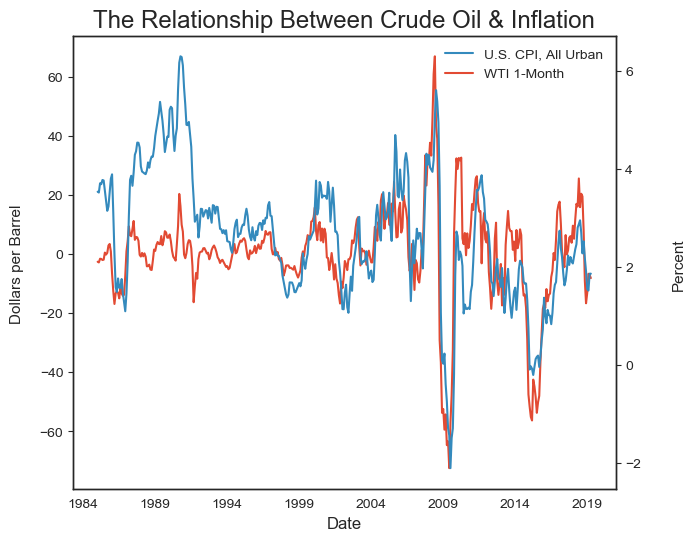

RMSE, Root Mean Square Error: 16.201
MSE, Mean Square Error: 262.47
PearsonR Correlation Coefficient: 0.612
R2, Coefficient of Determination: 0.374


In [181]:
plt.style.use('ggplot')
sns.set_style("white")
fig= plt.figure(num=None, figsize=(7, 6), dpi=100)
ax2 = df["CL1"].plot(label='WTI 1-Month')
ax1 = df["CPI"].plot(secondary_y=True, label='U.S. CPI, All Urban')
ax1 = plt.gca()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc="best", frameon=False)
plt.title('The Relationship Between Crude Oil & Inflation', fontsize='xx-large')
plt.figtext(0.035, 0.5, 'Dollars per Barrel', va='center', rotation='vertical', fontsize=11)
plt.figtext(0.98, 0.5, 'Percent', va='center', rotation='vertical', fontsize=11)
ax1.tick_params(axis='x', rotation=0)
plt.show()

RMSEtrain = (((df["CL1"] - df["CPI"]) ** 2).mean() ** .5)
MSEtrain = ((df["CL1"] - df["CPI"]) ** 2).mean()
CORRtrain = df["CL1"].corr(df["CPI"])
R2train = (df["CL1"].corr(df["CPI"])**2)

print("RMSE, Root Mean Square Error:", round(RMSEtrain,3))
print("MSE, Mean Square Error:", round(MSEtrain,3))
print("PearsonR Correlation Coefficient:", round(CORRtrain,3))
print("R2, Coefficient of Determination:", round(R2train,3))

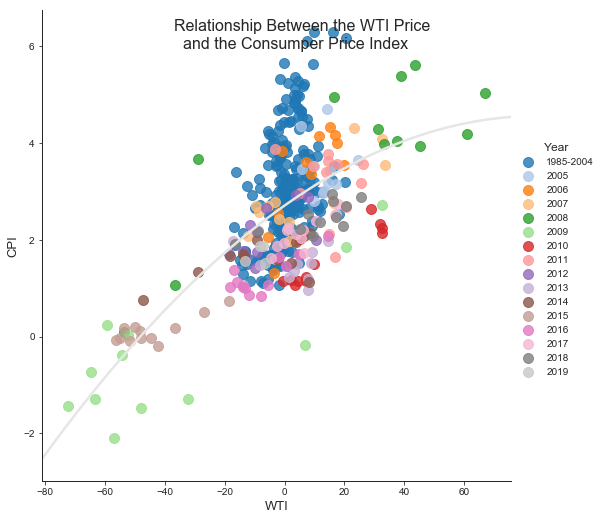

In [182]:
sns.set_style("white")
sns.set_style("ticks")

df.iloc[0:240, 7:8] = "1985-2004"

plot1 = sns.lmplot(x="CL1", y="CPI", data=df, hue='Year', fit_reg=False,  
        
    height = 7.3, aspect = 1, palette="tab20",
    order=2, ci=None,  scatter_kws={"s": 100});

plot1 = sns.regplot("CL1", "CPI", data=df, color=".9", scatter=False, order=2, ci=False, line_kws={"lw":2.5});

csfont = {'fontname':'Times New Roman'}

#plt.figtext(0.12, 0.10, "Data Source: EIA Weekly Petroleum Status Report", fontsize= 11)
plt.figtext(0.30, 0.9, "Relationship Between the WTI Price \n  and the Consumper Price Index", fontsize= 16)
plt.xlabel("WTI", fontsize = 13)
plt.ylabel('CPI', fontsize = 13)
plt.show()

#### Copper

Every year, a vast amount of copper is used by the global economy to manufacture a wide variety of goods. It's a major ingredient in big-ticket consumer goods like autos, appliances, electronics, and new homes. Simultaneously, copper is also gobbled up for many industrial uses including telecommunications, utilities, construction, and industrial machinery. Copper’s long history of predicting economic movements has famously earned it a nickname "Doctor Copper" or as the metal “with a Ph.D. in economics”.

In [183]:
df['CopperDummy'] = ((df.index >='2006-01-01') & (df.index <='2011-06-01')).astype(int)
m1 = smapi.OLS.from_formula('Copper ~ CopperDummy', df).fit()
df['Copper'] = m1.resid

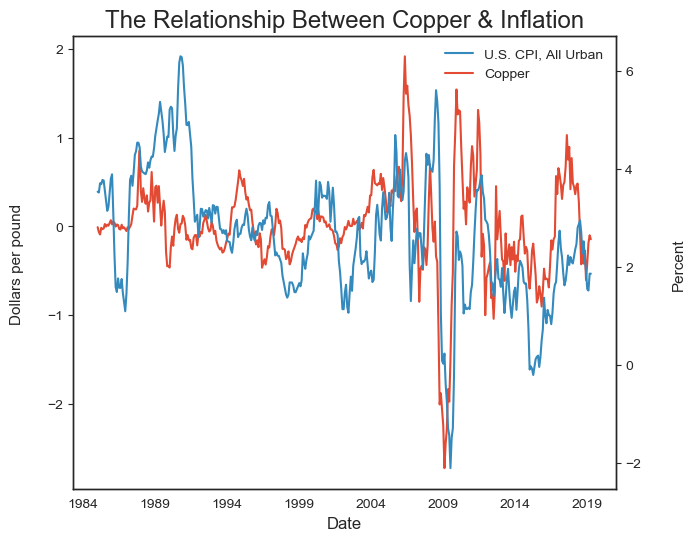

RMSE, Root Mean Square Error: 2.9
MSE, Mean Square Error: 8.412
PearsonR Correlation Coefficient: 0.374
R2, Coefficient of Determination: 0.14


In [184]:
plt.style.use('ggplot')
sns.set_style("white")
fig= plt.figure(num=None, figsize=(7, 6), dpi=100)
ax2 = df["Copper"].plot(label='Copper')
ax1 = df["CPI"].plot(secondary_y=True, label='U.S. CPI, All Urban')
ax1 = plt.gca()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc="best", frameon=False)
plt.title('The Relationship Between Copper & Inflation', fontsize='xx-large')
plt.figtext(0.035, 0.5, 'Dollars per pound', va='center', rotation='vertical', fontsize=11)
plt.figtext(0.98, 0.5, 'Percent', va='center', rotation='vertical', fontsize=11)
ax1.tick_params(axis='x', rotation=0)
plt.show()

RMSEtrain = (((df["Copper"] - df["CPI"]) ** 2).mean() ** .5)
MSEtrain = ((df["Copper"] - df["CPI"]) ** 2).mean()
CORRtrain = df["Copper"].corr(df["CPI"])
R2train = (df["Copper"].corr(df["CPI"])**2)

print("RMSE, Root Mean Square Error:", round(RMSEtrain,3))
print("MSE, Mean Square Error:", round(MSEtrain,3))
print("PearsonR Correlation Coefficient:", round(CORRtrain,3))
print("R2, Coefficient of Determination:", round(R2train,3))

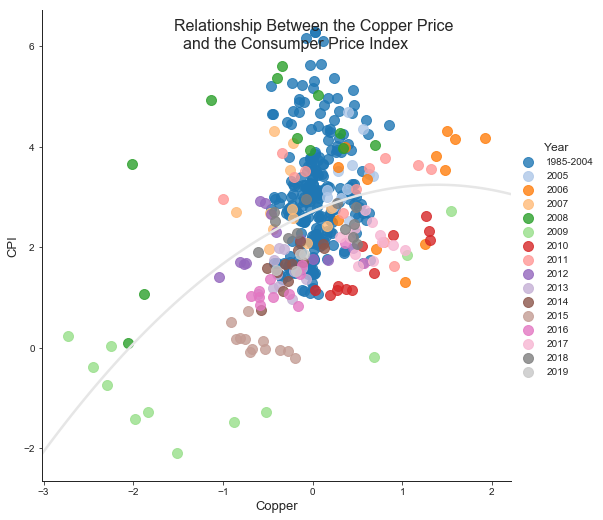

In [185]:
sns.set_style("white")
sns.set_style("ticks")

df.iloc[0:240, 7:8]  = "1985-2004"

plot1 = sns.lmplot(x="Copper", y="CPI", data=df, hue='Year', fit_reg=False,  
        
    height = 7.3, aspect = 1, palette="tab20",
    order=2, ci=None,  scatter_kws={"s": 100});

plot1 = sns.regplot("Copper", "CPI", data=df, color=".9", scatter=False, order=2, ci=False, line_kws={"lw":2.5});

csfont = {'fontname':'Times New Roman'}

#plt.figtext(0.12, 0.10, "Data Source: EIA Weekly Petroleum Status Report", fontsize= 11)
plt.figtext(0.30, 0.9, "Relationship Between the Copper Price \n  and the Consumper Price Index", fontsize= 16)
plt.xlabel("Copper", fontsize = 13)
plt.ylabel('CPI', fontsize = 13)
plt.show()

### UnemploymentRate

The U.S. Bureau of Labor Statistics (BLS) publishes a monthly "Employment Situation Summary" with key statistics and commentary regarding unemployment in the United States. A person is defined as unemployed in the United States if they are jobless, but have looked for work in the last four weeks and are available for work. People who are neither employed nor defined as unemployed are not included in the labor force calculation. 

William Phillips was an economist from New Zealand who spotted that when employment levels are high, wages and inflation rises. And likewise when unemployment is high the lack of money spent means that inflation goes down. This became known as the phillips curve.

* If the unemployment rate is low, workers have more leverage and options. 
* If workers have more leverage, owners have to increase wages to attract and retain workers. 
* If wages rise, workers increased buying power increases the demand for goods and services.
* The increased demand for goods and services will increase inflation.

In [186]:
df['EmploymentDummy'] = ((df.index >='2010-06-01') & (df.index <='2050-12-01')).astype(int)
m1 = smapi.OLS.from_formula('EmploymentRate ~ EmploymentDummy', df).fit()
df['EmploymentRate'] = m1.resid

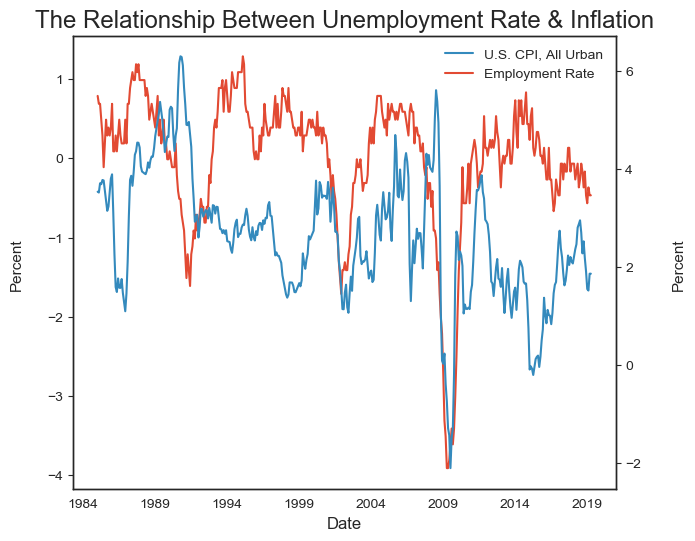

RMSE, Root Mean Square Error: 2.951
MSE, Mean Square Error: 8.711
PearsonR Correlation Coefficient: 0.296
R2, Coefficient of Determination: 0.088


In [187]:
plt.style.use('ggplot')
sns.set_style("white")
fig= plt.figure(num=None, figsize=(7, 6), dpi=100)
ax2 = df["EmploymentRate"].plot(label='Employment Rate')
ax1 = df["CPI"].plot(secondary_y=True, label='U.S. CPI, All Urban')
ax1 = plt.gca()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc="best", frameon=False)
plt.title('The Relationship Between Unemployment Rate & Inflation', fontsize='xx-large')
plt.figtext(0.035, 0.5, 'Percent', va='center', rotation='vertical', fontsize=11)
plt.figtext(0.98, 0.5, 'Percent', va='center', rotation='vertical', fontsize=11)
ax1.tick_params(axis='x', rotation=0)
plt.show()

RMSEtrain = (((df["EmploymentRate"] - df["CPI"]) ** 2).mean() ** .5)
MSEtrain = ((df["EmploymentRate"] - df["CPI"]) ** 2).mean()
CORRtrain = df["EmploymentRate"].corr(df["CPI"])
R2train = (df["EmploymentRate"].corr(df["CPI"])**2)

print("RMSE, Root Mean Square Error:", round(RMSEtrain,3))
print("MSE, Mean Square Error:", round(MSEtrain,3))
print("PearsonR Correlation Coefficient:", round(CORRtrain,3))
print("R2, Coefficient of Determination:", round(R2train,3))

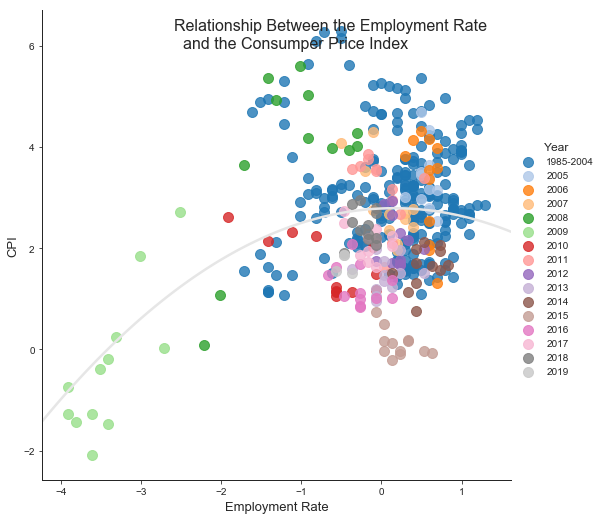

In [188]:
sns.set_style("white")
sns.set_style("ticks")

df.iloc[0:240, 6:7] = "1985-2004"

plot1 = sns.lmplot(x="EmploymentRate", y="CPI", data=df, hue='Year', fit_reg=False,  
        
    height = 7.3, aspect = 1, palette="tab20",
    order=2, ci=None,  scatter_kws={"s": 100});

plot1 = sns.regplot("EmploymentRate", "CPI", data=df, color=".9", scatter=False, order=2, ci=False, line_kws={"lw":2.5});


csfont = {'fontname':'Times New Roman'}

#plt.figtext(0.12, 0.10, "Data Source: EIA Weekly Petroleum Status Report", fontsize= 11)
plt.figtext(0.30, 0.9, "Relationship Between the Employment Rate \n  and the Consumper Price Index", fontsize= 16)
plt.xlabel("Employment Rate", fontsize = 13)
plt.ylabel('CPI', fontsize = 13)
plt.show()

### HousingStarts

The New Residential Construction Report, known as "housing starts" on Wall Street, is a monthly report issued by the U.S. Census Bureau jointly with the U.S. Department of Housing and Urban Development (HUD). The data is derived from surveys of homebuilders nationwide, and three metrics are provided: privately‐owned housing starts, building permits and housing completions. The housing start report is published on a monthly basis (comes out around the 17th of each month), with a one-month lag. A housing start is defined as beginning the foundation of the home itself. Building permits are counted as of when they are granted. 

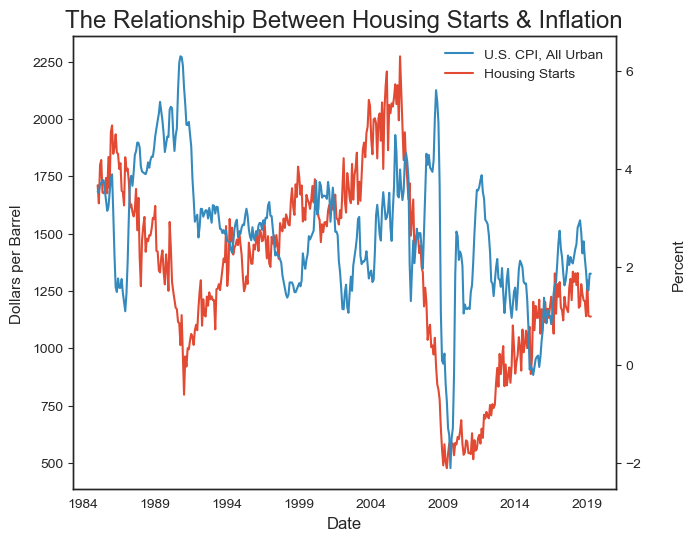

RMSE, Root Mean Square Error: 1400.344
MSE, Mean Square Error: 1960962.708
PearsonR Correlation Coefficient: 0.224
R2, Coefficient of Determination: 0.05


In [189]:
plt.style.use('ggplot')
sns.set_style("white")
fig= plt.figure(num=None, figsize=(7, 6), dpi=100)
ax2 = df["HousingStarts"].plot(label='Housing Starts')
ax1 = df["CPI"].plot(secondary_y=True, label='U.S. CPI, All Urban')
ax1 = plt.gca()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc="best", frameon=False)
plt.title('The Relationship Between Housing Starts & Inflation', fontsize='xx-large')
plt.figtext(0.035, 0.5, 'Dollars per Barrel', va='center', rotation='vertical', fontsize=11)
plt.figtext(0.98, 0.5, 'Percent', va='center', rotation='vertical', fontsize=11)
ax1.tick_params(axis='x', rotation=0)
plt.show()

RMSEtrain = (((df["HousingStarts"] - df["CPI"]) ** 2).mean() ** .5)
MSEtrain = ((df["HousingStarts"] - df["CPI"]) ** 2).mean()
CORRtrain = df["HousingStarts"].corr(df["CPI"])
R2train = (df["HousingStarts"].corr(df["CPI"])**2)

print("RMSE, Root Mean Square Error:", round(RMSEtrain,3))
print("MSE, Mean Square Error:", round(MSEtrain,3))
print("PearsonR Correlation Coefficient:", round(CORRtrain,3))
print("R2, Coefficient of Determination:", round(R2train,3))

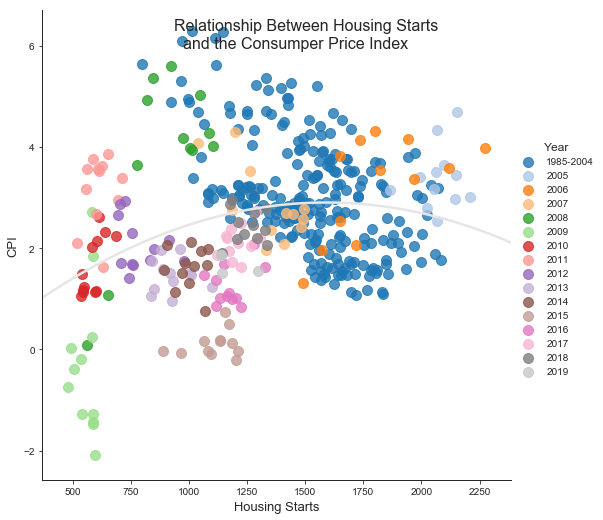

In [190]:
sns.set_style("white")
sns.set_style("ticks")

df.iloc[0:240, 6:7] = "1985-2004"

plot1 = sns.lmplot(x="HousingStarts", y="CPI", data=df, hue='Year', fit_reg=False,  
        
    height = 7.3, aspect = 1, palette="tab20",
    order=2, ci=None,  scatter_kws={"s": 100});

plot1 = sns.regplot("HousingStarts", "CPI", data=df, color=".9", scatter=False, order=2, ci=False, line_kws={"lw":2.5});


csfont = {'fontname':'Times New Roman'}

#plt.figtext(0.12, 0.10, "Data Source: EIA Weekly Petroleum Status Report", fontsize= 11)
plt.figtext(0.30, 0.9, "Relationship Between Housing Starts \n  and the Consumper Price Index", fontsize= 16)
plt.xlabel("Housing Starts", fontsize = 13)
plt.ylabel('CPI', fontsize = 13)
plt.show()

### Earnings

In [191]:
df['Trend'] = range(1, len(df) + 1)
df['EarningsDummy'] = ((df.index >='2008-10-01') & (df.index <='2009-10-01')).astype(int)

m1 = smapi.OLS.from_formula('Earnings ~ Trend + EarningsDummy', df).fit()
df['Earnings'] = m1.resid

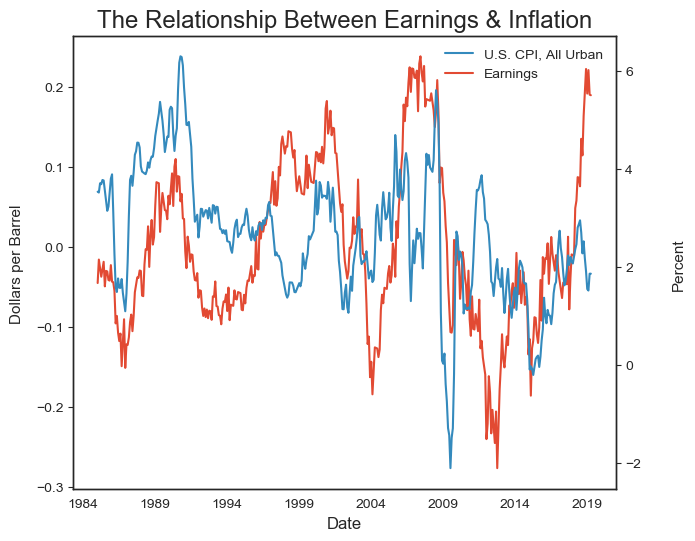

RMSE, Root Mean Square Error: 2.931
MSE, Mean Square Error: 8.592
PearsonR Correlation Coefficient: 0.264
R2, Coefficient of Determination: 0.069


In [192]:
plt.style.use('ggplot')
sns.set_style("white")
fig= plt.figure(num=None, figsize=(7, 6), dpi=100)
ax2 = df["Earnings"].plot(label='Earnings')
ax1 = df["CPI"].plot(secondary_y=True, label='U.S. CPI, All Urban')
ax1 = plt.gca()
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc="best", frameon=False)
plt.title('The Relationship Between Earnings & Inflation', fontsize='xx-large')
plt.figtext(0.035, 0.5, 'Dollars per Barrel', va='center', rotation='vertical', fontsize=11)
plt.figtext(0.98, 0.5, 'Percent', va='center', rotation='vertical', fontsize=11)
ax1.tick_params(axis='x', rotation=0)
plt.show()

RMSEtrain = (((df["Earnings"] - df["CPI"]) ** 2).mean() ** .5)
MSEtrain = ((df["Earnings"] - df["CPI"]) ** 2).mean()
CORRtrain = df["Earnings"].corr(df["CPI"])
R2train = (df["Earnings"].corr(df["CPI"])**2)

print("RMSE, Root Mean Square Error:", round(RMSEtrain,3))
print("MSE, Mean Square Error:", round(MSEtrain,3))
print("PearsonR Correlation Coefficient:", round(CORRtrain,3))
print("R2, Coefficient of Determination:", round(R2train,3))

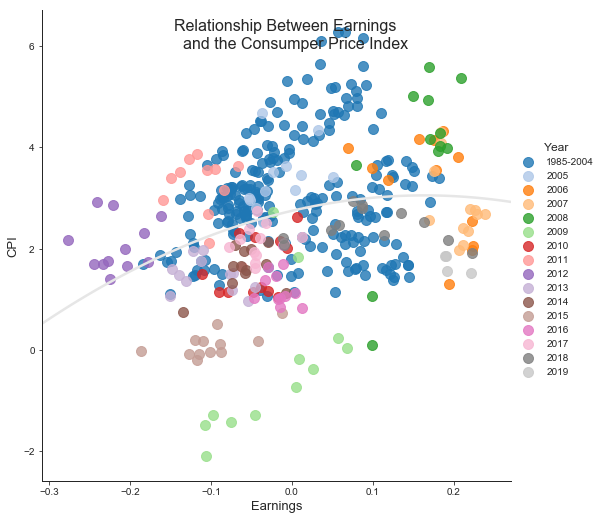

In [193]:
sns.set_style("white")
sns.set_style("ticks")

df.iloc[0:240, 6:7] = "1985-2004"

plot1 = sns.lmplot(x="Earnings", y="CPI", data=df, hue='Year', fit_reg=False,  
        
    height = 7.3, aspect = 1, palette="tab20",
    order=2, ci=None,  scatter_kws={"s": 100});

plot1 = sns.regplot("Earnings", "CPI", data=df, color=".9", scatter=False, order=2, ci=False, line_kws={"lw":2.5});

csfont = {'fontname':'Times New Roman'}

#plt.figtext(0.12, 0.10, "Data Source: EIA Weekly Petroleum Status Report", fontsize= 11)
plt.figtext(0.30, 0.9, "Relationship Between Earnings \n  and the Consumper Price Index", fontsize= 16)
plt.xlabel("Earnings", fontsize = 13)
plt.ylabel('CPI', fontsize = 13)
plt.show()

### Emperical Result

In [194]:
X = df[['CL1','Copper', 'EmploymentRate', 'HousingStarts','Earnings']]
y = df["CPI"]

X.fillna(method='ffill', inplace=True)
y.fillna(method='ffill', inplace=True)

X1 = X.values
y1=y.values

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, shuffle=False) 


#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [195]:
# The pipeline class allows sticking multiple processes into a single scikit-learn estimator

# Similar to ridge regression, introduces small amount of bias for smaller variance 
# Ridge works best when most of variables in our model are useful, otherwise use lasso
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

# Elastic-net regression combines lasso regression penalty with the ridge regression penalty   
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)


GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [196]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 1.6050 (0.7149)

ElasticNet score: 1.6050 (0.7150)

Kernel Ridge score: 1.8320 (1.0477)

Gradient Boosting score: 1.6246 (0.5162)

Xgboost score: 1.6828 (0.5416)

LGBM score: 1.6914 (0.5644)



In [197]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [198]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 1.5923 (0.6794)



In [199]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [200]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 1.6270 (0.4894)


In [201]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [202]:
stacked_averaged_models.fit(X_train, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train)
stacked_pred = stacked_averaged_models.predict(X_test)
print(rmsle(y_train, stacked_train_pred))

0.2949918919124839


In [203]:
ntrain = stacked_train_pred.shape[0]
ntest = stacked_train_pred.shape[0]

train = df.iloc[:ntrain]
test = df.iloc[ntrain:]

stacked_train_pred = pd.DataFrame(stacked_train_pred)
stacked_train_pred.index = train.index

stacked_train_pred.columns = ["Forecast"]

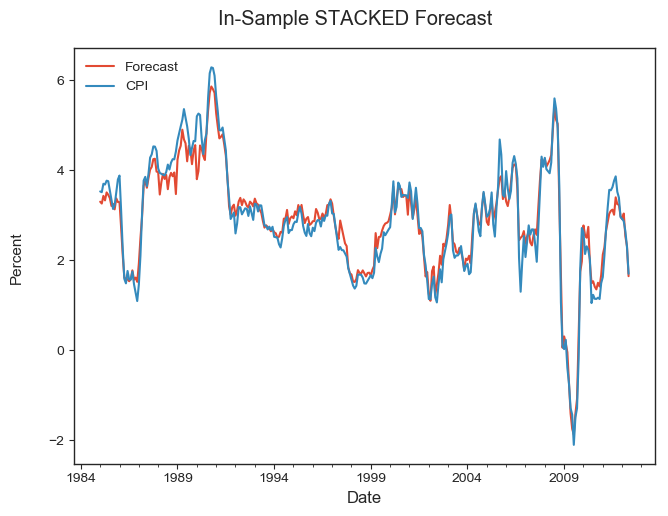

In [204]:
# Out-Of-Sample
sns.set_style("white")
sns.set_style("ticks")

fig= plt.figure(num=None, figsize=(7.5, 5.5), dpi=100)
plt.suptitle('In-Sample STACKED Forecast', x=0.5, y=0.95, ha='center', fontsize='x-large')
ax = stacked_train_pred["Forecast"].plot(label='Forecast')
ax = train['CPI'].plot(label='CPI')
plt.figtext(0.04, 0.5, 'Percent', va='center', rotation='vertical', fontsize=11)
plt.legend(frameon=False)
plt.show()

In [205]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = model_xgb.predict(X_test)
print(rmsle(y_train, xgb_train_pred))

0.15001023237832742


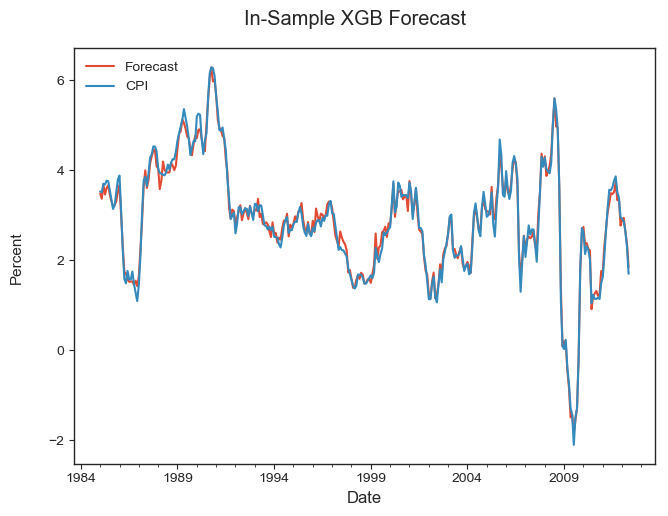

In [206]:
xgb_train_pred = pd.DataFrame(xgb_train_pred)
xgb_train_pred.index = train['CPI'].index
xgb_train_pred.columns = ["Forecast"]

# Out-Of-Sample
sns.set_style("white")
sns.set_style("ticks")
fig= plt.figure(num=None, figsize=(7.5, 5.5), dpi=100)
plt.suptitle('In-Sample XGB Forecast', x=0.5, y=0.95, ha='center', fontsize='x-large')
ax = xgb_train_pred["Forecast"].plot(label='Forecast')
ax = train['CPI'].plot(label='CPI')
ax = plt.gca()
plt.figtext(0.04, 0.5, 'Percent', va='center', rotation='vertical', fontsize=11)
plt.legend(frameon=False)
plt.show()

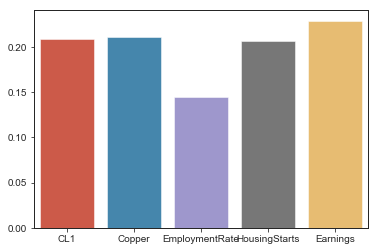

In [207]:
coeff_df = pd.DataFrame(model_xgb.feature_importances_, X.columns, columns=['Coefficient'])  

coeff_df1 = coeff_df.T

sns.barplot(data = coeff_df1) #, palette="Set3")
plt.show()

In [208]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = model_lgb.predict(X_test)
print(rmsle(y_train, lgb_train_pred))

0.5788868068192099


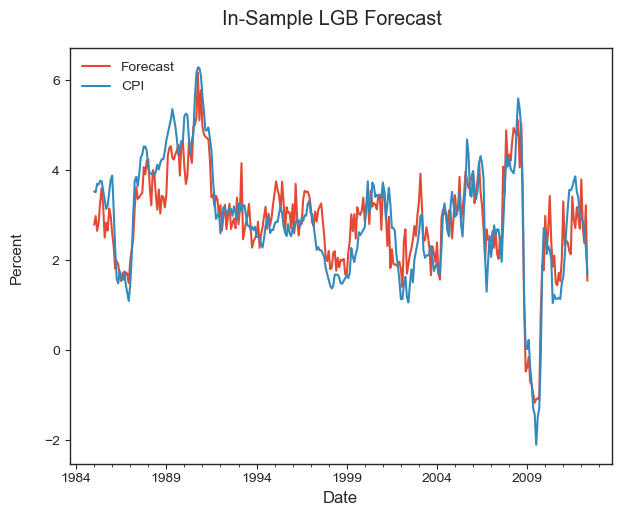

In [209]:
lgb_train_pred = pd.DataFrame(lgb_train_pred)
lgb_train_pred.index = train['CPI'].index
lgb_train_pred.columns = ["Forecast"]

# Out-Of-Sample
sns.set_style("white")
sns.set_style("ticks")
fig= plt.figure(num=None, figsize=(7, 5.5), dpi=100)
plt.suptitle('In-Sample LGB Forecast', x=0.5, y=0.95, ha='center', fontsize='x-large')
ax = lgb_train_pred["Forecast"].plot(label='Forecast')
ax = train['CPI'].plot(label='CPI')
#ax = plt.gca().set_size_inches(7, 5.5)
plt.figtext(0.04, 0.5, 'Percent', va='center', rotation='vertical', fontsize=11)
plt.legend(frameon=False)
plt.show()

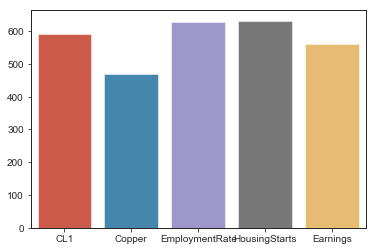

In [210]:
coeff_df = pd.DataFrame(model_lgb.feature_importances_, X.columns, columns=['Coefficient'])  

coeff_df1 = coeff_df.T

sns.barplot(data = coeff_df1) #, palette="Set3")
plt.show()

In [235]:
ensemble = (stacked_pred*0.8) + (xgb_pred*0.1) + (lgb_pred*0.1)
ensamble1 = pd.DataFrame(ensemble)
ensamble1.index = test.index
ensamble1_columns =["Forecast"]
ensamble1.columns =ensamble1_columns

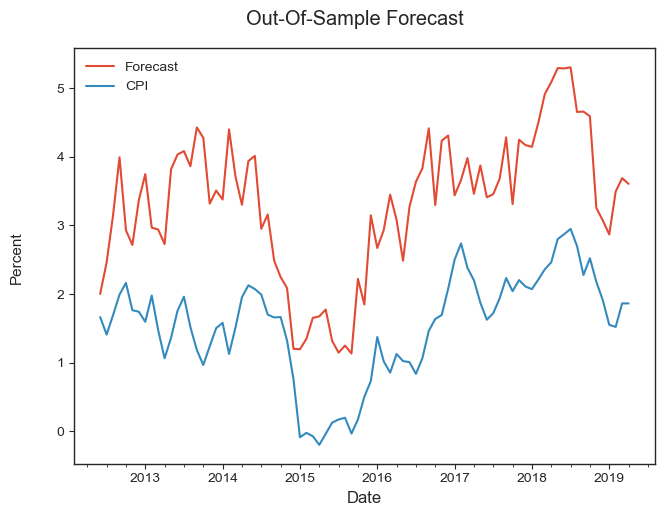

RMSE, Root Mean Square Error: 1.9
MSE, Mean Square Error: 3.611
PearsonR Correlation Coefficient: 0.782
R2, Coefficient of Determination: 0.611


In [236]:
# Out-Of-Sample
sns.set_style("white")
sns.set_style("ticks")
fig= plt.figure(num=None, figsize=(7.5, 5.5), dpi=100)
plt.suptitle('Out-Of-Sample Forecast', x=0.5, y=0.95, ha='center', fontsize='x-large')
ax = ensamble1["Forecast"].plot(label='Forecast')
ax = test['CPI'].plot(label='CPI')
ax = plt.gca()
plt.figtext(0.04, 0.5, 'Percent', va='center', rotation='vertical', fontsize=11)
plt.legend(frameon=False)
plt.show()


RMSEtest = (((ensamble1["Forecast"] - test['CPI']) ** 2).mean() ** .5)
MSEtest = ((ensamble1["Forecast"] - test['CPI']) ** 2).mean()
CORRtest = ensamble1["Forecast"].corr(test['CPI'])
R2test = (ensamble1["Forecast"].corr(test['CPI'])**2)

print("RMSE, Root Mean Square Error:", round(RMSEtest,3))
print("MSE, Mean Square Error:", round(MSEtest,3))
print("PearsonR Correlation Coefficient:", round(CORRtest,3))
print("R2, Coefficient of Determination:", round(R2test,3))